# Updates for Marty

## 1. Notation updates
To align more closely with the standard jargon used by transportation engineers, I have
made several changes (for which I would welcome feedback).

### 1a. Population densities
First, recall that our model is built on the fundamental relation:
$$
q = k * v
$$
where $q$=flow (vehicles / time), $k$=density (vehicles / space), and $v$=speed (space / time).

In our model, we are tracking "populations" (previously called $P$ and $C$) of vehicles,
but they are really population densities (although we don't explicitly specify the spatial area).
To make this fact more explicit, I have renamed:
- $P(t) \to kp(t)$
- $C(t) \to kc(t)$

I considered using Julia's "magic" notation to write `k\_p` and `k\_c`. However, for 
some reason Julia automatically changes `k\_c` to `k\_chi`, and there does not appear to
be a way to prevent this. So I am sticking with `kp(t)` and `kc(t)` in the code.

We might also consider changing $kp$ to $kz$ and replacing the word "patches" with the word
"zones", as this is typical used by transportation engineers (for instance, when developing 4-step models).

### 1b. Diurnal "demand" function
We have been using a variable $d$ which we called "demand" to refer to the fraction of a 
patch population which desires to leave (start travelling) at any given time. In 
transportation engineering, "demand" usually refers to a value of flow ($q$). Also, the 
letter "d" usually refers to a distance. 
To avoid confusion, I have renamed:
- $d(t) \to \gamma(t)$
- For now I am still using the word "demand" to refer to $\gamma$, but we should probably think of a different word

Finally, for our diurnal demand function, we are using the logistic equation which is usually written
$$
f(x, k, x_0, L) = L / (1 + exp(-k * (x - x_0)))
$$
where $x$ is the input, $k$ is the intrinsic growth rate, $x_0$ is the $x$ value of the function's midpoint, and $L$ is the carrying capacity. However, I want to preserve $k$ to refer to vehicle densities. Therefore I have renamed:
- $k \to r$ and $my_k \to my_r$ (for passing parameters)

## 2. Trouble in Paradise
I am observing a few behaviors which are not what we want. Marty, after you run the following code, please attempt the following changes so that you can see what happens. If you want to change back to the default conditions, see the very last code cell in this notebook:
1. Make the day shorter:
- By default, `my_period=1440`. Change this to `my_period=120`. Think of this as a "day" which is only 2 hours long. Run the code and notice that the maximum values of `kc` for any corridor have increased -- they now exceed `kc_jam` (the horizontal lines). The jam-densities (`kc_jam`) for each corridor have not changed.
2. Look at only part of a day:
- To convince yourself that 1. is true, now set `my_period=1440` and `my_t_end=480` (or any value between 360 and 1440). You have now created a 24-hour day, but you are only running the model for part of that day. Observe that the maximum values of `kc` still do not ever exceed their associated `kc_jam`.
3. Shift the peak demand time:
- This isn't really a problem, I just want you to see how it works
- Try setting `my_shift = 3 * 60` (or any non-zero multiple of 60). Observe that the demand function now peaks later than `v` (or `-v` in the case of afternoon demand).
- Read the comment on the function `v_shifted()` in `help_funcs.jl`. Notice I am using a trig identity, and therefore am still calling upon `sin` and `cos` functions (not purely relying on `u` and `v`) before passing an `x` to `f(x, r, x_0, L)`. I'm not sure how else to accomplish a shift. For instance, I can't pass `v + my_shift` as `x` in `f(x, r, x_0, L)` because this shifts `v` up and down, not left and right.

## 3. Other problems I / we still need to work out:
4. Why do we never see values of `average_speed = v_f`? I set the free-flow velocity `my_v_f = 90`, but we never see speeds as high as 90 in subplot 2.
5. Why don't our average velocities decrease *more* in the presence of traffic congestion?
6. Once we have `Np > 2`, we will need to think about "attraction" *to* patches, not just "demand" *from* patches. 
- In many transportation engineering models, a gravity model is used, where `R` (the distance between two bodies) is given by the "impedence" (think of this like a "friction factor"). Impedence is sometimes defined as e.g. total trip time, trip cost, inverse jam density, etc. or some combination of multiple factors.

In [286]:
# Fast call for helper functions to run model
path_to_help_funcs = "/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl" # CHANGE FOR YOURSELF
include(path_to_help_funcs)
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

In [287]:
#=
Set initial conditions, parameters, and other arguments to pass to model solver
=#

Np = 2 # Number of patches
Nc = 1 # Number of corridors

# Set initial conditions
kp_init = [1.0; 0.0]
kc_init = zeros(Np, Np, Nc)
u_init = 1
v_init = 0

# Set timescale
my_period = 1440    # 24 hours, in minutes
my_t_end = my_period     # Change if you only want to examine part of a day (< my_period), or multiple days (> my_period)
scale = 1440 / my_period # if using a period other than 1440, this will rescale the other parameters

# Set parameters
my_α = [1]   # Tolerance for congestion (for now, assume same for patch 1 and patch 2)
my_kc_jam = 10 * ones(Np, Np, Nc)  # Inverse road capacity (for now, assume same for all corridors)
my_kc_jam[[CartesianIndex(i, i, k) for i in 1:Np, k in 1:Nc]] .= 1e9 # set diagonal values to almost Inf
display(my_kc_jam)

# TEST: set C_init to C_jam
#kc_init[1,2,1] = 1 ./ my_kc_jam[1,2,1] + 0.05 # Should be 1/20
display(kc_init)

# Arguments for demand function (which is f() = L / (1 + exp(-r * (x-x0))) )
demand_function = "periodic_logistic" # Other option is "static"
my_L = 0.6
my_r = 100
my_x0 = 0.99
my_shift = 0 * 60    # in units of minutes, set to 0 for no shift

# Parameters for calculating space-mean speed
my_v_f = 90
my_a = 20

2×2×1 Array{Float64, 3}:
[:, :, 1] =
  1.0e9  10.0
 10.0     1.0e9

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

20

## Current problem
Using `calc_space_mean_speed()`, I get speeds very close to 90. When I use `speed_density_curve()` directly, I get the range of speeds I'm expecting. So what is happening inside of `calc_space_mean_speed()` that is messing things up? A little confusing to work with because I have to specify `t` (at least, I think I do).

2×2×1 Array{Float64, 3}:
[:, :, 1] =
  1.0e9  10.0
 10.0     1.0e9

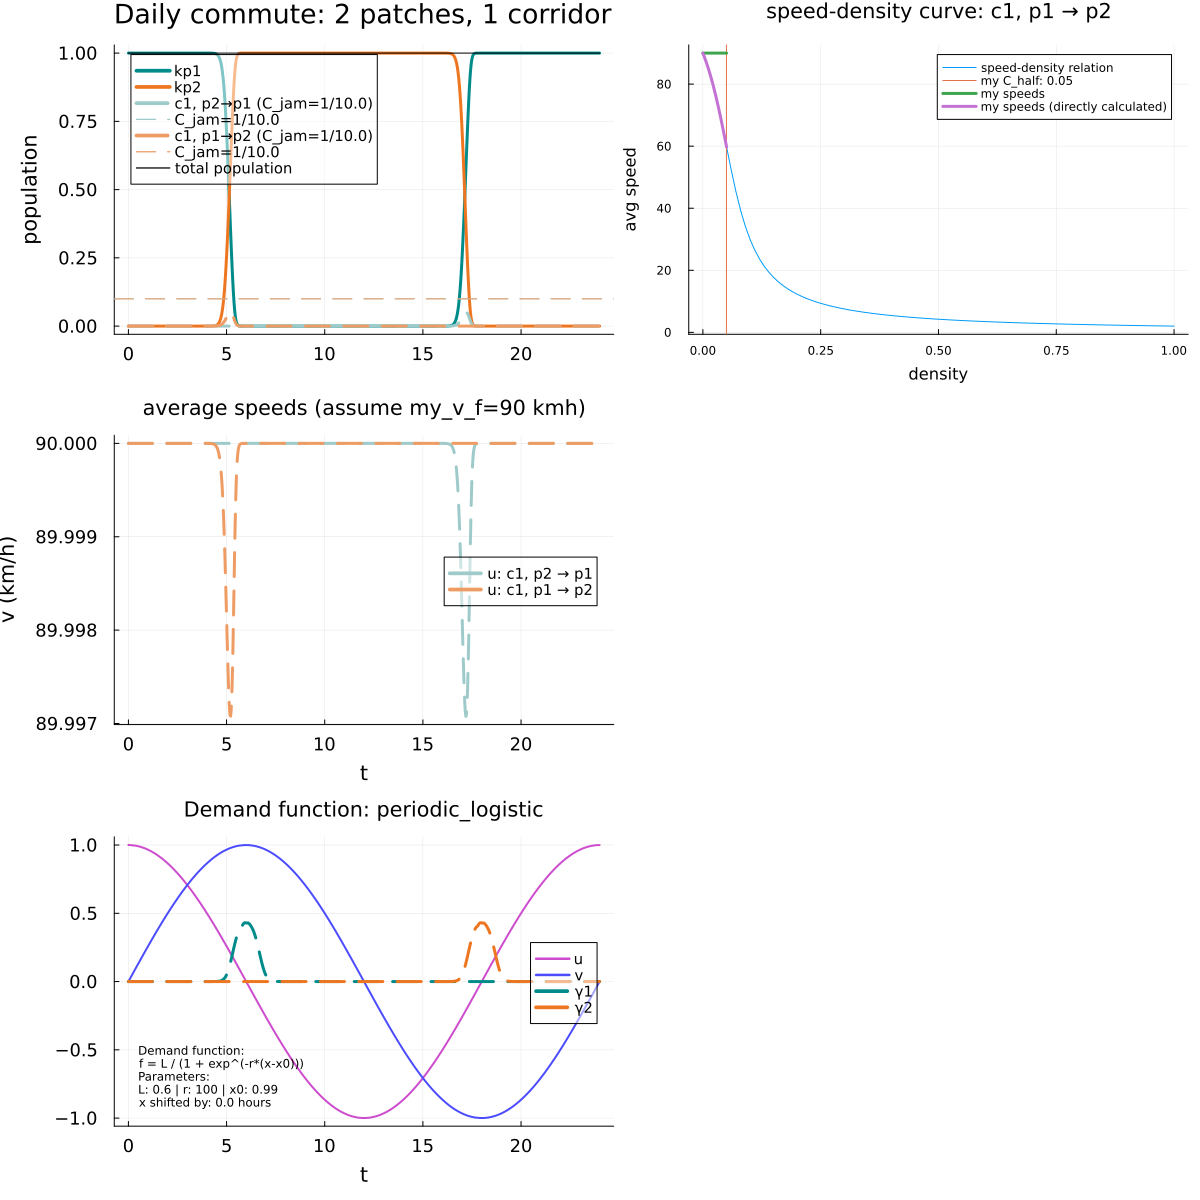

In [288]:
#=
Build model, solve problem, plot results, and save
=#

model, prob, sol, plt = HelpFuncs.build_symbolic_model_diurnal(Np=Np, Nc=Nc, 
    my_kp=kp_init, my_kc=kc_init, my_u=u_init, my_v=v_init, my_α=my_α, my_kc_jam=my_kc_jam, 
    γ_version = demand_function, my_period = my_period, t_end = my_t_end, my_v_f=my_v_f, my_a=my_a, my_L=my_L, 
    my_r=my_r, my_x0=my_x0, my_shift=my_shift)

# Suffix to specify test
suffix = "_original" #"_shut_off_entry_flux" #"_new_speed_density" #"_shut_off_entry_flux" #"_shut_off_exit_flux"

# Save plot
if demand_function == "periodic_logistic"
    savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc" * "_t_end_$my_t_end" * "_L_$my_L" * "_r_$my_r" * "_x0_$my_x0" * "_shift_$my_shift" * "_timescale_$scale" * suffix * ".png")
else
    savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc" * "_t_end_$my_t_end" * "_timescale_$scale" * suffix * ".png")
end
display(plt)

In [211]:
function speed_density_curve(; v_f, a, C, C_half)
    return (v_f / ((pi / 2 .- atan(a .* (0 .- C_half))) / pi)) .* (pi / 2 .- atan.(a .* (C .- C_half))) / pi
end

#speed(v_f, a, C, C_half) = (v_f/((pi/2 -atan(a .* (0 .- C_half)))/pi)) .* (pi/2 -atan.(a .* (C .- C_half)))/pi

my_C_range = [0.0:0.01:1;]
my_v_f = 90
my_a = 20
my_speeds_test = speed_density_curve.(v_f=my_v_f, a=my_a, C=my_C_range, C_half=0.5)

101-element Vector{Float64}:
 90.0
 89.94022929750818
 89.87799434936727
 89.81314013938082
 89.7454984237092
 89.67488629528913
 89.60110455800316
 89.52393588066452
 89.44314269540723
 89.35846479844356
 89.26961660310988
 89.17628398531261
 89.07812064948112
  ⋮
  3.7725663873347166
  3.679233769537441
  3.590385574203764
  3.5057076772400984
  3.4249144919827845
  3.347745814644176
  3.2739640773581877
  3.2033519489381503
  3.1357102332665097
  3.070856023280043
  3.0086210751391427
  2.9488503726473336

## Play with functional forms for speed-density relation

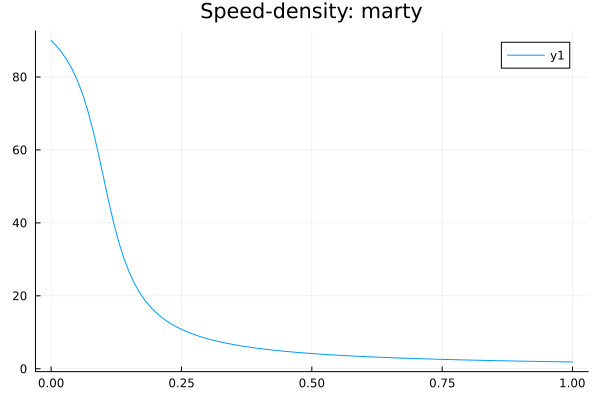

In [150]:
version_name = "marty" # Choose your fighter

if version_name == "original"
    my_C = [-10.0:0.01:10.0;]
    speed(v_f, a, C, C_half) = -(v_f / pi) .* atan.(a * (C .- C_half)) .+ (v_f / 2)
elseif version_name == "new"
    my_C = [0.0:0.01:1;]
    speed(v_f, a, C, C_half) = -(v_f / pi) .* atan.(a .* v_f .* (tan.(pi .* (C - 0.5)) .- C_half)) .+ (v_f / 2)
    #speed(v_f, a, C, C_half) = -(v_f / pi) .* atan.(a .* v_f .* (tan.(pi .* (C .+ 0.5)) .- C_half)) .+ (v_f / 2)
    # Problem -- I need to shift C - 0.5, but - C_half is not doing anything
elseif version_name == "marty"
    speed(v_f, a, C, C_half) = (v_f/((pi/2 -atan(a .* (0 .- C_half)))/pi)) .* (pi/2 -atan.(a .* (C .- C_half)))/pi
    #s(x,sharp,shift,vmax) = (vmax/((pi/2 -atan(sharp*(0-shift)))/pi))*(pi/2 -atan(sharp*(x-shift)))/pi
end

my_a = 20        # sharp
my_C_half = 1/10 # shift
my_v_f = 90      # vmax

speeds = speed.(my_v_f, my_a, my_C, my_C_half)
plt = plot(my_C, speeds)
title!(plt, "Speed-density: $version_name")
savefig(plt, "speed_density_curve_$version_name.png")
display(plt)

In [41]:
#=
View model
=#

model

Model model with 8 equations
Unknowns (8):
  u(t)
  v(t)
  (kp(t))[1]
  (kp(t))[2]
  (kc(t))[1, 1, 1]
  (kc(t))[2, 1, 1]
⋮
Parameters (3):
  period
  α[1]
  kc_jam

Default parameter settings (in case of accidental overwrite)

In [42]:
#=
Default ICs and parameter settings
=#

Np = 2 # Number of patches
Nc = 1 # Number of corridors

# Set initial conditions
kp_init = [1.0; 0.0]
kc_init = zeros(Np, Np, Nc)
u_init = 1
v_init = 0

# Set parameters
my_α = [1]   # Tolerance for congestion (for now, assume same for patch 1 and patch 2)
my_kc_jam = 10 * ones(Np, Np, Nc)    # Inverse road capacity (for now, assume same for all corridors)
my_kc_jam[[CartesianIndex(i, i, k) for i in 1:Np, k in 1:Nc]] .= 1e9 # set diagonal values to almost Inf
display(my_kc_jam)

# Arguments for demand function (which is f() = L / (1 + exp(-r * (x-x0))) )
demand_function = "periodic_logistic" # Other option is "static"
my_L = 0.6
my_r = 100
my_x0 = 0.99
my_shift = 0 * 60    # in units of minutes, set to 0 for no shift
my_period = 1440     # 24 hours, in minutes
my_t_end = my_period # Change if you only want to examine part of a day (< my_period), or multiple days (> my_period)

2×2×1 Array{Float64, 3}:
[:, :, 1] =
  1.0e9  10.0
 10.0     1.0e9

1440